# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:**_Jorge A. Morales Alfaro 
*Semester:* Fall 2023

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
#pip install --upgrade  threadpoolctl

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

2023-12-15 18:54:52.446332: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

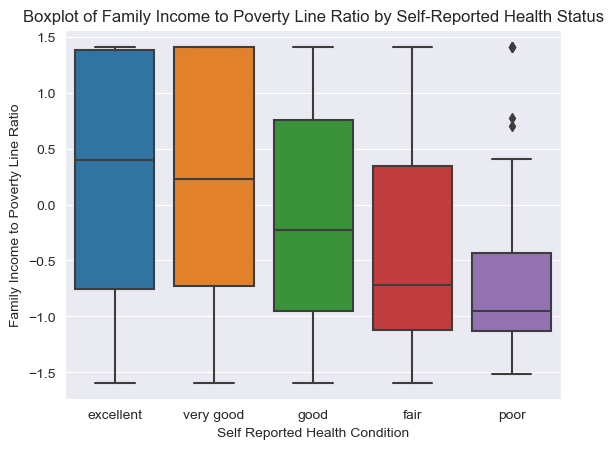

In [4]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

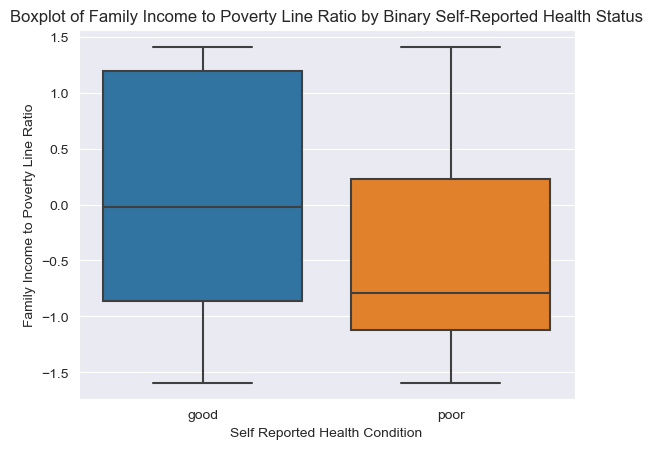

In [5]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

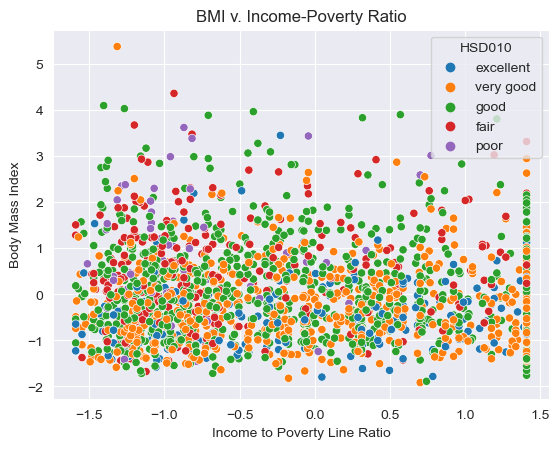

In [6]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [7]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

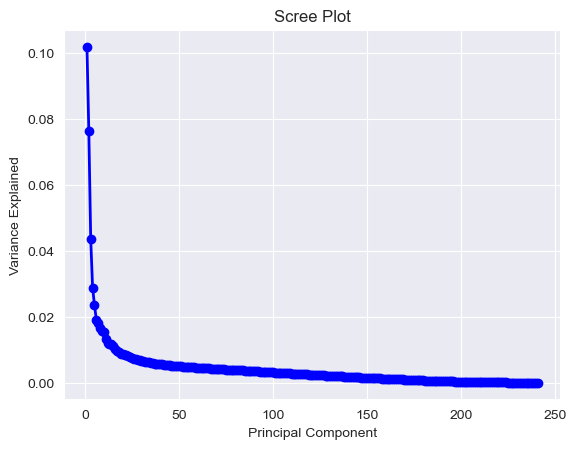

In [8]:
# We will make a PCA without limit, creating all the Principal components,
#then I will use a Scree plot and a bar plot to determine how many would be ideal
#--------------------------------------------------
np.random.seed(555)
# fit PCA
# ----------
pca_all = PCA() 
principalComponents_health = pca_all.fit_transform(nhanes_scaled)


# create scree plot from PCA fit
# ----------
PC_values = np.arange(pca_all.n_components_) + 1
plt.plot(PC_values, pca_all.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

It seems like after the 5 or 6th component curve starts to have very diminishing improvements. 
Still, There is some variance to recover at least until the 20-25th component. 
Which is not too bad, as we are coming from a 250 features dataset. 

### Barplot of Components

In [9]:
## I will then reduce the number of components to 20 and do a barplot to further analyze if I shoudl decrease the size


pca20 = PCA(n_components=20)
principalComponents_health20 = pca20.fit_transform(nhanes_scaled)

In [10]:
## Your Answer Here
variance_df = pd.DataFrame({'Principal Component': [f'PC{i+1}' for i in range(len(pca20.explained_variance_ratio_))],
                            'Variance Explained': pca20.explained_variance_ratio_})



In [11]:
# convert into a dataframe
# ----------

num_components = principalComponents_health20.shape[1]  # Number of principal components
columns = [f'principal component {i+1}' for i in range(num_components)]

pca_df = pd.DataFrame(data = principalComponents_health20, columns = columns)


In [12]:
pca_df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,principal component 11,principal component 12,principal component 13,principal component 14,principal component 15,principal component 16,principal component 17,principal component 18,principal component 19,principal component 20
0,9.527811,-0.816224,-1.867090,-2.109892,-3.929294,-0.185683,-3.844800,-2.934948,1.515702,0.683973,0.120778,2.232560,0.284649,-0.654383,0.412075,-0.640991,0.352945,0.479144,-0.502138,2.294842
1,-5.838339,-3.692573,3.805751,-1.029616,0.394502,1.591797,2.712994,-0.739719,0.385884,-2.405193,-0.455442,1.095680,0.468465,2.419563,0.503833,-1.361836,0.590741,-0.650669,-1.490594,1.899403
2,-0.719454,-2.573200,0.907903,-4.755835,-1.798878,0.863717,-1.024231,0.632360,0.540469,0.447583,0.168263,-1.317741,1.705656,-0.271960,0.458442,-0.765012,-0.002881,-0.523914,0.375148,3.291438
3,3.533627,-2.576982,-3.249123,-0.405349,3.999210,1.443931,-1.181528,0.328007,-4.145221,-1.245504,-0.783603,2.068753,-2.346114,2.816273,-1.132660,-1.283340,1.144368,0.614260,0.107755,-1.096708
4,-6.872094,-4.194241,0.886832,-0.848957,-0.524810,0.072990,0.844501,0.985883,0.556338,-0.044216,-0.501676,-0.986643,-0.573329,-1.840725,-0.270546,-0.088507,-0.688705,-0.234532,2.173843,3.039866


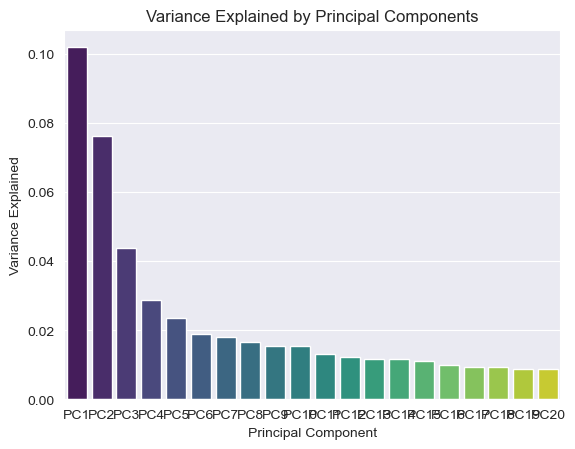

In [13]:

sns.barplot(x='Principal Component', y='Variance Explained', data=variance_df, palette='viridis')
plt.title('Variance Explained by Principal Components')
plt.show()

### How many components will you use to fit a supervised learning model?

After the graphical analysis, I am inclined to keep 5 to 10 components. I think for simplicty 5 would be ideal, but the accumulated variance does not seem to be a lot, so I am afrad I would loose valuable information. I'll keep 10 as that still makes my model clear to understand and interpret and preservees enough information. 

### 2D Scatterplot of the first two components

In [14]:

# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
pca_df['HSD010_binary'] = hsd010
pca_df['HSD010_binary'] = pca_df['HSD010_binary'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 

In [15]:
pca_df.head(100)

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,...,principal component 12,principal component 13,principal component 14,principal component 15,principal component 16,principal component 17,principal component 18,principal component 19,principal component 20,HSD010_binary
0,9.527811,-0.816224,-1.867090,-2.109892,-3.929294,-0.185683,-3.844800,-2.934948,1.515702,0.683973,...,2.232560,0.284649,-0.654383,0.412075,-0.640991,0.352945,0.479144,-0.502138,2.294842,good
1,-5.838339,-3.692573,3.805751,-1.029616,0.394502,1.591797,2.712994,-0.739719,0.385884,-2.405193,...,1.095680,0.468465,2.419563,0.503833,-1.361836,0.590741,-0.650669,-1.490594,1.899403,good
2,-0.719454,-2.573200,0.907903,-4.755835,-1.798878,0.863717,-1.024231,0.632360,0.540469,0.447583,...,-1.317741,1.705656,-0.271960,0.458442,-0.765012,-0.002881,-0.523914,0.375148,3.291438,good
3,3.533627,-2.576982,-3.249123,-0.405349,3.999210,1.443931,-1.181528,0.328007,-4.145221,-1.245504,...,2.068753,-2.346114,2.816273,-1.132660,-1.283340,1.144368,0.614260,0.107755,-1.096708,good
4,-6.872094,-4.194241,0.886832,-0.848957,-0.524810,0.072990,0.844501,0.985883,0.556338,-0.044216,...,-0.986643,-0.573329,-1.840725,-0.270546,-0.088507,-0.688705,-0.234532,2.173843,3.039866,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5.368887,-1.246562,1.794866,-2.356273,4.306454,4.120396,-1.502574,2.401699,0.048416,0.223134,...,-0.213869,-1.111582,-1.771401,-0.352426,0.103597,-0.145342,-1.120715,1.729696,-2.342444,good
96,-3.800793,-1.153132,-0.192103,-0.666487,0.671990,-0.960983,0.876831,-2.343283,-0.863819,-1.865708,...,-3.081780,0.268201,0.905105,1.159131,-0.330951,-0.648781,0.920888,0.059614,-2.789206,good
97,-3.187486,-1.724905,7.382479,-1.526182,-0.049840,1.923867,2.635596,1.623670,1.353747,-0.432171,...,3.188518,0.305717,-3.359833,-2.347904,-1.349490,-1.681042,-0.438927,-1.086747,3.870769,good
98,-9.483802,12.310936,-2.126295,-2.140628,-1.573639,3.667399,3.213713,-0.241490,-1.118638,-1.058275,...,2.977800,-0.282330,0.323632,0.663888,2.433202,-3.108760,-3.334385,-0.520445,1.755003,good


<Figure size 640x480 with 0 Axes>

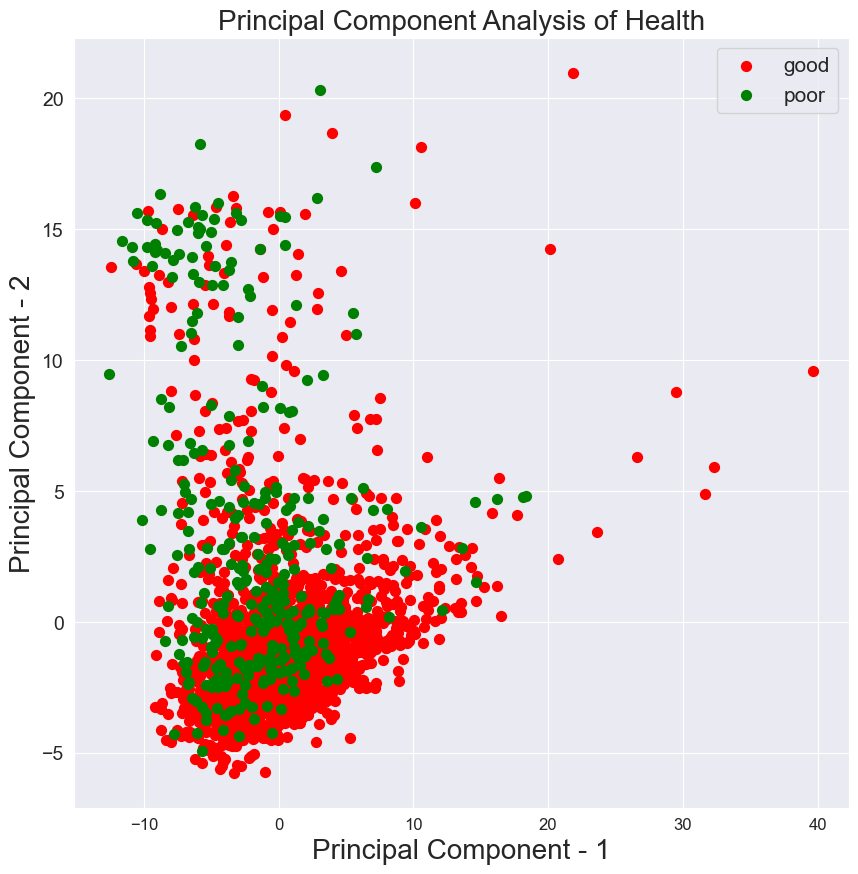

In [16]:
#I'll do the scatter plot of the first two componets 



# figure settings
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Health",fontsize=20)
targets = ['good', 'poor']
colors = ['r', 'g']

# loop over targets and colors to create scatterplot
for target, color in zip(targets,colors):
    indicesToKeep = pca_df['HSD010_binary'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

# show figure
plt.legend(targets,prop={'size': 15})
plt.show();


## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

I will use K-Means clustering. K-means algorithm clusters data by separating samples in n groups of equal variance. It minimizes the criterion known as the inertia or within-cluster sum-of-squares. The user needs to define the number of clusters but it can be defined based on the amount of variance explained by different number of clusters. 



### Cluster nhanes

In [17]:
#nhanes_scaled = nhanes_scaled.drop([ 'HSD010_binary'], axis = 1)

In [18]:
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ033,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,-0.680203,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,-0.680203,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812


In [19]:
#I will use the Elbow method to find the number of clusters for a KMeans 
distortions = []
K = range (1,10)
for k in K: 
    kmeanModel = KMeans (n_clusters=k)
    kmeanModel.fit(nhanes_scaled)
    distortions.append (kmeanModel.inertia_)

/var/folders/h0/y99pnxk16js0gj2tnr5d18d00000gn/T/ipykernel_78913/481288098.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, distortions, 'bx-', c='r')


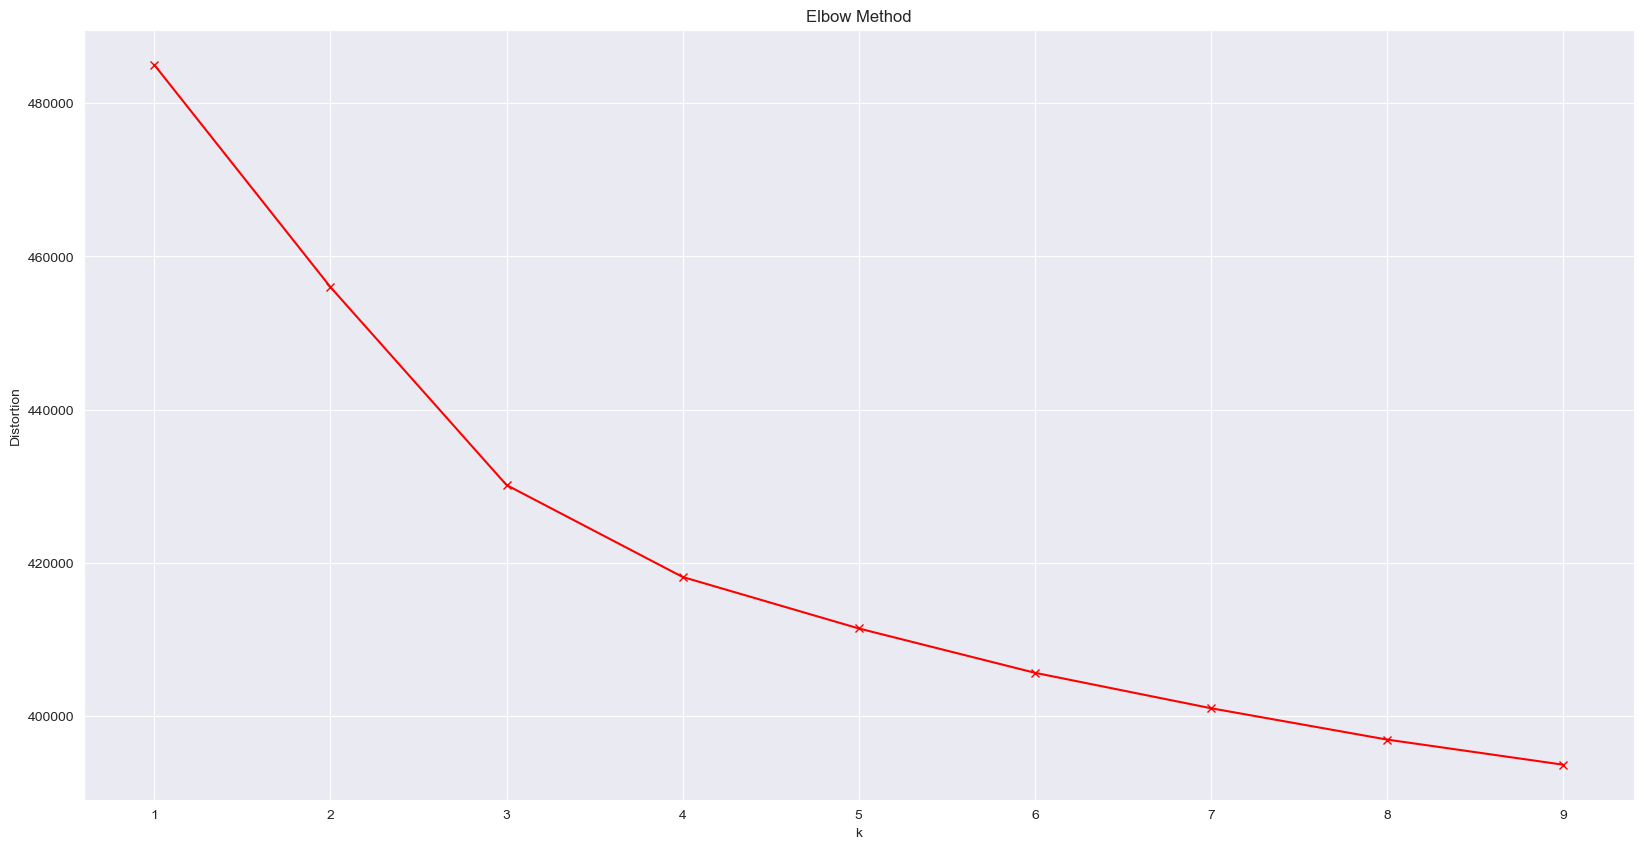

In [20]:
#Plot the distortions of K-means
plt.figure(figsize=(20,10))
plt.plot(K, distortions, 'bx-', c='r') 
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

It seems like the elbow method point towards including 6 or 7 clusters, after 7 there is not much benefit. I'll start with 7 clusters. 

In [21]:
# Obtaining a K- means cluster of 7 clusters
kmeans = KMeans(n_clusters=7,
                 n_init=10,
               max_iter=1000 
               ).fit(nhanes_scaled)

In [22]:
# print the centers 
print("Centers")
print(kmeans.cluster_centers_)
print()

# print labels
print("Labels")
print(kmeans.labels_)
print()

# print coordinates and labels 
for point, label in zip(nhanes_scaled, kmeans.labels_):
    print("Coordinates:", point, "Label:", label)

Centers
[[ 0.         -0.02056839  0.         ... -0.02717127  0.13608097
   0.12372621]
 [ 0.          0.02757286  0.         ... -0.07950478 -0.18278401
   0.32487117]
 [ 0.         -0.05491162  0.         ...  0.04902108  0.05691794
   0.09629047]
 ...
 [ 0.          0.00380677  0.         ...  0.02519311  0.04492392
  -1.04734102]
 [ 0.          0.06060664  0.         ...  0.16866576  0.34758345
   0.61244043]
 [ 0.         -0.1349905   0.         ...  0.30439209  0.28269604
   0.61244043]]

Labels
[3 4 4 ... 0 3 1]

Coordinates: DR1DRSTZ Label: 3
Coordinates: DR1EXMER Label: 4
Coordinates: DRABF Label: 4
Coordinates: DRDINT Label: 3
Coordinates: DR1DBIH Label: 4
Coordinates: DR1DAY Label: 2
Coordinates: DR1LANG Label: 4
Coordinates: DR1MNRSP Label: 5
Coordinates: DR1HELPD Label: 1
Coordinates: DBQ095Z Label: 3
Coordinates: DRQSPREP Label: 5
Coordinates: DR1STY Label: 0
Coordinates: DRQSDIET Label: 3
Coordinates: DR1TNUMF Label: 4
Coordinates: DR1TKCAL Label: 1
Coordinates: DR1TPRO

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

In [23]:
nhanes_scaled['cluster']=kmeans.labels_

In [24]:
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,cluster
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,3
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,4
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,4
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,3
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,4


In [25]:
BMI_Income = ['INDFMPIR', 'BMXBMI', 'cluster']  
bmi_inc_df = nhanes_scaled[BMI_Income]

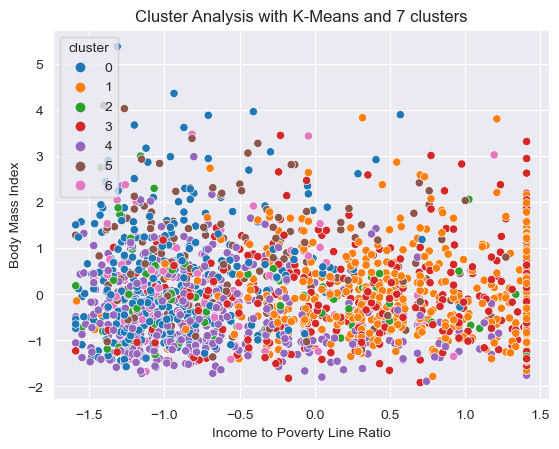

In [26]:
#Plot the clusters over BMI and Income Poverty Radio 
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue="cluster", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
       ylabel = "Body Mass Index")
ax.set_title("Cluster Analysis with K-Means and 7 clusters")
plt.show()

In [27]:
# That was not clear at all, lets see how it looks with 3 clusters. Obtaining a K- means cluster of 3 clusters
kmeans = KMeans(n_clusters=3,
                 n_init=10,
               max_iter=1000 
               ).fit(nhanes_scaled)

In [28]:
nhanes_scaled['cluster3']=kmeans.labels_

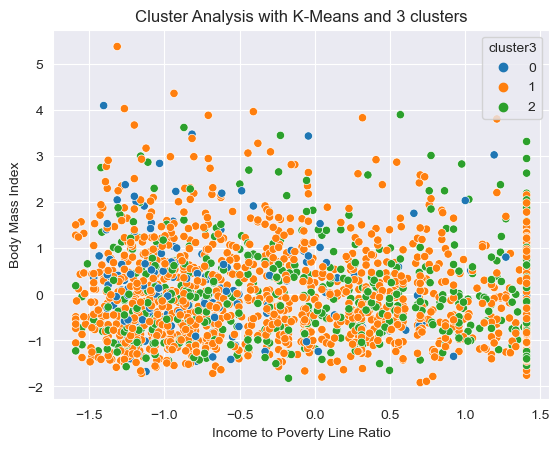

In [29]:
#Plot the clusters over BMI and Income Poverty Radio 
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue="cluster3", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
       ylabel = "Body Mass Index")
ax.set_title("Cluster Analysis with K-Means and 3 clusters")
plt.show()

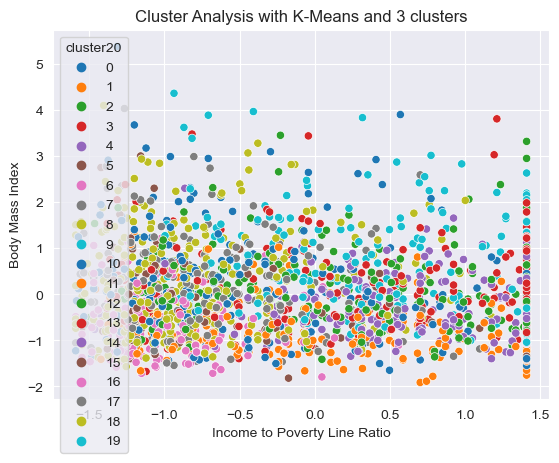

In [30]:
#Lets make 20 clusters and see 
kmeans = KMeans(n_clusters=20,
                 n_init=10,
               max_iter=1000 
               ).fit(nhanes_scaled)

nhanes_scaled['cluster20']=kmeans.labels_
#Plot the clusters over BMI and Income Poverty Radio 
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue="cluster20", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
       ylabel = "Body Mass Index")
ax.set_title("Cluster Analysis with K-Means and 20 clusters")
plt.show()

I will keep the 7 cluster for now.  The problem might be just in these two features we are plotting. 
We can't really distinguish the clustering among this two variables using this method. Even when changing the number of clusters, this could be due to eh fact that I am using K-means and we have many features. 

## Your Answer Here

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [32]:
pca_df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,...,principal component 12,principal component 13,principal component 14,principal component 15,principal component 16,principal component 17,principal component 18,principal component 19,principal component 20,HSD010_binary
0,9.527811,-0.816224,-1.867090,-2.109892,-3.929294,-0.185683,-3.844800,-2.934948,1.515702,0.683973,...,2.232560,0.284649,-0.654383,0.412075,-0.640991,0.352945,0.479144,-0.502138,2.294842,good
1,-5.838339,-3.692573,3.805751,-1.029616,0.394502,1.591797,2.712994,-0.739719,0.385884,-2.405193,...,1.095680,0.468465,2.419563,0.503833,-1.361836,0.590741,-0.650669,-1.490594,1.899403,good
2,-0.719454,-2.573200,0.907903,-4.755835,-1.798878,0.863717,-1.024231,0.632360,0.540469,0.447583,...,-1.317741,1.705656,-0.271960,0.458442,-0.765012,-0.002881,-0.523914,0.375148,3.291438,good
3,3.533627,-2.576982,-3.249123,-0.405349,3.999210,1.443931,-1.181528,0.328007,-4.145221,-1.245504,...,2.068753,-2.346114,2.816273,-1.132660,-1.283340,1.144368,0.614260,0.107755,-1.096708,good
4,-6.872094,-4.194241,0.886832,-0.848957,-0.524810,0.072990,0.844501,0.985883,0.556338,-0.044216,...,-0.986643,-0.573329,-1.840725,-0.270546,-0.088507,-0.688705,-0.234532,2.173843,3.039866,good


In [33]:
pca_df = pca_df.drop(['HSD010_binary'], axis = 1)

cluster_pca = KMeans(n_clusters=7,
               max_iter=10000).fit(pca_df)

In [34]:
pca_df['cluster_pca']=cluster_pca.labels_
pca_df['cluster_pca']

0       1
1       0
2       0
3       1
4       0
       ..
2059    1
2060    6
2061    6
2062    1
2063    3
Name: cluster_pca, Length: 2064, dtype: int32

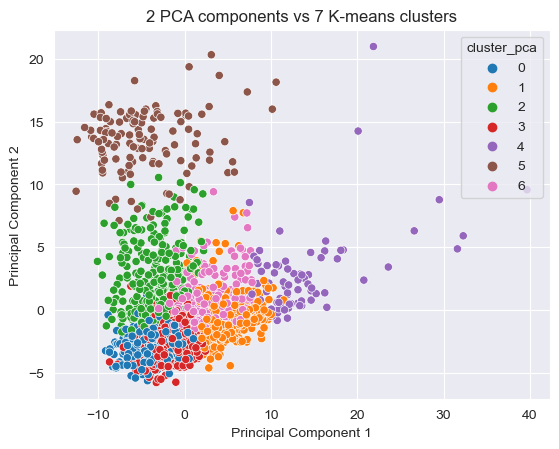

In [49]:
#Plot four clusters on the first two principal components
np.random.seed(555)

ax = sns.scatterplot(x = "principal component 1", y = "principal component 2", hue="cluster_pca", palette = "tab10", data = pca_df)
ax.set(xlabel = "Principal Component 1",
       ylabel = "Principal Component 2")
ax.set_title("2 PCA components vs 7 K-means clusters")
plt.show()

The result is clear on how  PCAs components and clusters are capturing similar associations. I had 20 PCAs and 7 clusters, so in both cases I diminished the size of the features in an important scale and it seems I am capturing similar information with both. I like that clustering helps to identify elements that are in between the PCA components, for example the pinnk cluster (6) and blue (0) both central an to the left and down (even if i set a random seed the colors and numbers change when i run it, so just making sure that you see which ones I am refering to) capture groups that might be hard to separate otherwise. Clearly there are other components that are playing a role on the clustering as clusters are not overlapping exactly each component. 


## Your Answer Here

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [36]:

nhanes_scaled.head() 

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,cluster,cluster3,cluster20
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,3,2,10
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,4,1,6
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,4,1,1
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,3,2,19
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,4,1,17


In [37]:
# I will use the binary variable 
#partition data

# -----------


y =  hsd010_binary  # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
y = y.replace(["good", "poor"], [0,1])  # converting to numeric




X = nhanes_scaled.drop(['cluster','cluster3', 'cluster20'], axis = 1)  # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10, stratify =y)

In [38]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 2


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes, dtype ="uint8")
y_test = keras.utils.to_categorical(y_test, num_classes,dtype ="uint8")


num_classes = y_test.shape[1]

print( num_classes)

n_features = X_train.shape[1]

print( n_features)

print(y_train[1]) 
print(y_test[1]) 

2
241
[1 0]
[1 0]


In [39]:
# create neural network model
# -----------
np.random.seed(555)

model = Sequential()

model.add(Dense(n_features, input_dim= n_features, kernel_initializer='normal', activation='relu'))

model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))

## Add any additional layers you wish here

model.compile(loss= "categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

Epoch 1/10
8/8 - 1s - loss: 0.5206 - accuracy: 0.7565 - val_loss: 0.3870 - val_accuracy: 0.8527 - 969ms/epoch - 121ms/step
Epoch 2/10
8/8 - 0s - loss: 0.3351 - accuracy: 0.8682 - val_loss: 0.3745 - val_accuracy: 0.8702 - 229ms/epoch - 29ms/step
Epoch 3/10
8/8 - 0s - loss: 0.2963 - accuracy: 0.8844 - val_loss: 0.3670 - val_accuracy: 0.8682 - 122ms/epoch - 15ms/step
Epoch 4/10
8/8 - 0s - loss: 0.2645 - accuracy: 0.8934 - val_loss: 0.3583 - val_accuracy: 0.8624 - 152ms/epoch - 19ms/step
Epoch 5/10
8/8 - 0s - loss: 0.2339 - accuracy: 0.9128 - val_loss: 0.3487 - val_accuracy: 0.8605 - 125ms/epoch - 16ms/step
Epoch 6/10
8/8 - 0s - loss: 0.2116 - accuracy: 0.9212 - val_loss: 0.3431 - val_accuracy: 0.8643 - 83ms/epoch - 10ms/step
Epoch 7/10
8/8 - 0s - loss: 0.1909 - accuracy: 0.9322 - val_loss: 0.3440 - val_accuracy: 0.8547 - 80ms/epoch - 10ms/step
Epoch 8/10
8/8 - 0s - loss: 0.1730 - accuracy: 0.9419 - val_loss: 0.3472 - val_accuracy: 0.8605 - 85ms/epoch - 11ms/step
Epoch 9/10
8/8 - 0s - loss

The results of the Neural Network using all of the features gives an 86.24% of validation accuracy. 

### Neural Network on Principal Components

In [40]:
## Now lets do the same but with the PCAs created before 
pca_df.head()



,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,...,principal component 12,principal component 13,principal component 14,principal component 15,principal component 16,principal component 17,principal component 18,principal component 19,principal component 20,cluster_pca
0,9.527811,-0.816224,-1.867090,-2.109892,-3.929294,-0.185683,-3.844800,-2.934948,1.515702,0.683973,...,2.232560,0.284649,-0.654383,0.412075,-0.640991,0.352945,0.479144,-0.502138,2.294842,1
1,-5.838339,-3.692573,3.805751,-1.029616,0.394502,1.591797,2.712994,-0.739719,0.385884,-2.405193,...,1.095680,0.468465,2.419563,0.503833,-1.361836,0.590741,-0.650669,-1.490594,1.899403,0
2,-0.719454,-2.573200,0.907903,-4.755835,-1.798878,0.863717,-1.024231,0.632360,0.540469,0.447583,...,-1.317741,1.705656,-0.271960,0.458442,-0.765012,-0.002881,-0.523914,0.375148,3.291438,0
3,3.533627,-2.576982,-3.249123,-0.405349,3.999210,1.443931,-1.181528,0.328007,-4.145221,-1.245504,...,2.068753,-2.346114,2.816273,-1.132660,-1.283340,1.144368,0.614260,0.107755,-1.096708,1
4,-6.872094,-4.194241,0.886832,-0.848957,-0.524810,0.072990,0.844501,0.985883,0.556338,-0.044216,...,-0.986643,-0.573329,-1.840725,-0.270546,-0.088507,-0.688705,-0.234532,2.173843,3.039866,0


In [41]:
print(pca_df.shape)

(2064, 21)


In [42]:
X_pca = pca_df.drop(['cluster_pca'], axis=1)

In [43]:

#Training/Test split
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size = .25, 
                                                                    random_state = 10, stratify = y)

#Number of features
n_features_pca = X_train_pca.shape[1]

In [44]:
num_classes = 2
# convert class vectors to binary class matrices
y_train_pca = to_categorical(y_train_pca,num_classes, dtype ="uint8" )
y_test_pca = to_categorical(y_test_pca, num_classes, dtype ="uint8")
num_classes_pca = y_test_pca.shape[1]
print( num_classes_pca)
print( n_features_pca)

2
20


In [45]:
np.random.seed(555)

model_pca = Sequential()

model_pca.add(
    Dense(n_features_pca, input_dim= n_features_pca, kernel_initializer= 'normal', activation= 'relu')
)

model_pca.add(
    Dense(num_classes_pca, kernel_initializer= 'normal', activation= 'softmax')
)

## Add any additional layers you wish here

model_pca.compile(loss= "categorical_crossentropy", optimizer= 'adam', metrics=['accuracy'])

model_pca.fit(X_train_pca, y_train_pca, validation_data=(X_test_pca, y_test_pca), epochs=10, batch_size=200, verbose=2)

Epoch 1/10
8/8 - 1s - loss: 0.6826 - accuracy: 0.5846 - val_loss: 0.6620 - val_accuracy: 0.7306 - 668ms/epoch - 84ms/step
Epoch 2/10
8/8 - 0s - loss: 0.6468 - accuracy: 0.7791 - val_loss: 0.6292 - val_accuracy: 0.8236 - 89ms/epoch - 11ms/step
Epoch 3/10
8/8 - 0s - loss: 0.6143 - accuracy: 0.8346 - val_loss: 0.5979 - val_accuracy: 0.8391 - 77ms/epoch - 10ms/step
Epoch 4/10
8/8 - 0s - loss: 0.5829 - accuracy: 0.8391 - val_loss: 0.5678 - val_accuracy: 0.8391 - 70ms/epoch - 9ms/step
Epoch 5/10
8/8 - 0s - loss: 0.5527 - accuracy: 0.8391 - val_loss: 0.5386 - val_accuracy: 0.8391 - 73ms/epoch - 9ms/step
Epoch 6/10
8/8 - 0s - loss: 0.5230 - accuracy: 0.8398 - val_loss: 0.5107 - val_accuracy: 0.8391 - 69ms/epoch - 9ms/step
Epoch 7/10
8/8 - 0s - loss: 0.4952 - accuracy: 0.8404 - val_loss: 0.4840 - val_accuracy: 0.8391 - 83ms/epoch - 10ms/step
Epoch 8/10
8/8 - 0s - loss: 0.4686 - accuracy: 0.8417 - val_loss: 0.4596 - val_accuracy: 0.8430 - 69ms/epoch - 9ms/step
Epoch 9/10
8/8 - 0s - loss: 0.4445 

The validation accuracy using the 20 Components from the PCA was reduced to 83.91% which is not very differnt from the 86% using all features and has a significative smaller dimension, easing computing. 

### Neural Network on Principal Components + Cluster Membership

In [46]:
## Here we go again, this time with the PCA and Cluster

pca_df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,...,principal component 12,principal component 13,principal component 14,principal component 15,principal component 16,principal component 17,principal component 18,principal component 19,principal component 20,cluster_pca
0,9.527811,-0.816224,-1.867090,-2.109892,-3.929294,-0.185683,-3.844800,-2.934948,1.515702,0.683973,...,2.232560,0.284649,-0.654383,0.412075,-0.640991,0.352945,0.479144,-0.502138,2.294842,1
1,-5.838339,-3.692573,3.805751,-1.029616,0.394502,1.591797,2.712994,-0.739719,0.385884,-2.405193,...,1.095680,0.468465,2.419563,0.503833,-1.361836,0.590741,-0.650669,-1.490594,1.899403,0
2,-0.719454,-2.573200,0.907903,-4.755835,-1.798878,0.863717,-1.024231,0.632360,0.540469,0.447583,...,-1.317741,1.705656,-0.271960,0.458442,-0.765012,-0.002881,-0.523914,0.375148,3.291438,0
3,3.533627,-2.576982,-3.249123,-0.405349,3.999210,1.443931,-1.181528,0.328007,-4.145221,-1.245504,...,2.068753,-2.346114,2.816273,-1.132660,-1.283340,1.144368,0.614260,0.107755,-1.096708,1
4,-6.872094,-4.194241,0.886832,-0.848957,-0.524810,0.072990,0.844501,0.985883,0.556338,-0.044216,...,-0.986643,-0.573329,-1.840725,-0.270546,-0.088507,-0.688705,-0.234532,2.173843,3.039866,0


In [47]:

X_pca_cluster= pca_df
 
#Training/Test split
X_train_pca_cluster, X_test_pca_cluster, y_train_pca_cluster, y_test_pca_cluster = train_test_split(X_pca_cluster, y, 
                                                                                                    test_size = .25, 
                                                                                                    random_state = 10, 
                                                                                                    stratify = y)
#Number of features
n_features_pca_cluster = X_train_pca_cluster.shape[1]

num_classes = 2
# convert class vectors to binary class matrices
y_train_pca_cluster = to_categorical(y_train_pca_cluster, dtype ="uint8")
y_test_pca_cluster = to_categorical(y_test_pca_cluster, dtype ="uint8")
num_classes_pca_cluster = y_test_pca.shape[1]
print( num_classes_pca_cluster)
print( n_features_pca_cluster)



2
21


In [48]:
np.random.seed(555)

model_pca_cluster = Sequential()

model_pca_cluster.add(
    Dense(n_features_pca_cluster, input_dim= n_features_pca_cluster, kernel_initializer= 'normal', activation= 'relu')
)

model_pca_cluster.add(
    Dense(num_classes_pca_cluster, kernel_initializer= 'normal', activation= 'softmax')
)


model_pca_cluster.compile(loss= "categorical_crossentropy", optimizer= 'adam', metrics=['accuracy'])

model_pca_cluster.fit(X_train_pca_cluster, y_train_pca_cluster, 
                      validation_data=(X_test_pca_cluster, y_test_pca_cluster), 
                      epochs=10, batch_size=200, verbose=2)

Epoch 1/10
8/8 - 1s - loss: 0.6748 - accuracy: 0.7358 - val_loss: 0.6527 - val_accuracy: 0.8508 - 1s/epoch - 127ms/step
Epoch 2/10
8/8 - 0s - loss: 0.6381 - accuracy: 0.8450 - val_loss: 0.6171 - val_accuracy: 0.8469 - 141ms/epoch - 18ms/step
Epoch 3/10
8/8 - 0s - loss: 0.6011 - accuracy: 0.8411 - val_loss: 0.5803 - val_accuracy: 0.8411 - 79ms/epoch - 10ms/step
Epoch 4/10
8/8 - 0s - loss: 0.5624 - accuracy: 0.8404 - val_loss: 0.5419 - val_accuracy: 0.8411 - 64ms/epoch - 8ms/step
Epoch 5/10
8/8 - 0s - loss: 0.5218 - accuracy: 0.8411 - val_loss: 0.5036 - val_accuracy: 0.8430 - 81ms/epoch - 10ms/step
Epoch 6/10
8/8 - 0s - loss: 0.4823 - accuracy: 0.8404 - val_loss: 0.4677 - val_accuracy: 0.8450 - 89ms/epoch - 11ms/step
Epoch 7/10
8/8 - 0s - loss: 0.4459 - accuracy: 0.8411 - val_loss: 0.4366 - val_accuracy: 0.8469 - 72ms/epoch - 9ms/step
Epoch 8/10
8/8 - 0s - loss: 0.4154 - accuracy: 0.8450 - val_loss: 0.4121 - val_accuracy: 0.8508 - 72ms/epoch - 9ms/step
Epoch 9/10
8/8 - 0s - loss: 0.3914 

The validation accuracy went up to 85.08% which is an improvement from the 83% and gets us closer to the original 86%. 
This means the clusters over the PCs are helping us to improve almost to the degree of having the full data. Again this is ideal for dimension reduction and improving computation times

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA is a dimensionality reduction tool, which creates components that are a linear combination of the original features. It is used to summarize variable information, it can help to solve issues of collinearity or computation times. It tries to preserve as much variation in the data. On the other hand, cluster analysis groups data points in a new structure. It helps find patterns, through different algorithms minimizing distances or other methods that maximize similarity. It is unsupervised learning as there are no labels to learn from, to it identifies the categories by its methods. Helps in exploratory data, but goes a step forward from PCA. PCA does not finds this patterns. 

## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

Yes I did find a difference, my results using neural networks with PCA and clusters came very close to the accuracy of the model with the full set of features. This is a clear example of how the combination of methods, reducing dimension, then finding clusters helps to keep as much variation as possible from the orifinal data. In my case, specifically I chose a threshold that was low for the PCs, as the variance coudl have still got gains if I have gone for 40 or 50 even more. But for interpretation and easeness of computing, 20 was better and alone it did loose some accuracy to predict. Thanks to the clustering, I was able to recover some of that accuracy, only by adding one feature. 

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Clearly, they help to reduce the dimensions of our datasets, which help to address the curse of dimensionality, times of computing, power of computing, and in some cases ease interpretability. It can also help us find some patterns that can give us ideas of how to better parametrize our SL models, or better understand the outcomes. 